# **Lecture Day 2 Practical** - 09/03/21
# **Time Series Analysis and Classification**

Today we will explore some of the topics we explored in todays Time Series Analysis Lecture. Our data domain in question is Nuclear Power plant neutron flux detector readings for a Pressurised Water Reactor (PWR).

For more details on this work check out the references section at the bottom of the notebook or just have a chat with me (Aiden)!

We will first undertake some straightforward time series pre-processing, then build a classifier network to determine which type of anomaly is present.

Any questions after the practical session just drop me an email:

a.durrant.20@abdn.ac.uk

 \- Aiden

##**Outline and Objectives:**
Today we aim to use the time series processing methods from the lecture to preprocess the reactor detector readings, augment the sequences for computational efficiency, construct a classifier to determine anomaly type, and visualise the output representations. 
- [ ] Remove noise
- [ ] Augment into smaller subsequences.
- [ ] Split the processed data to construct a training, validation, and test set.
- [ ] Normalize the data feature-wise!
- [ ] Build a Recurrent Neural Network (RNN) classifier.
- [ ] Build convolutional neural networks (CNNs) classifier.
- [ ] Train the model / tune the hyperparameters.
- [ ] Visualise the results via t-SNE to view the seperation of classes in representation space.

**Bonus Tasks (if you have time or find this interesting)**
- [ ] Train the model with the multi-class one hot labels to determine specific anomalies rather than scenarios!
- [ ] Implement an attention network classifier.

To check off the tasks update the markdown '- [ ]' -> to '- [x]'

## **Remember!**
Set your runtime type to allow GPU utilization!

`Runtime -> Change runtime type -> GPU`

If you get stuck with Colab check out the practical from Day one or have a look at these examples: \\
- https://colab.research.google.com/notebooks/intro.ipynb \\
- https://jupyter-notebook.readthedocs.io/en/stable/notebook.html


# **Data Description**
Let us first upload the appropriate dataset that can be found on MyAberdeen: `Day2_Practical_Data.zip`

This will contain 8 numpy `.npz` files each corresponding to a particular anomalous scenario (our classes) and readings of 56 detectors for 35 Seconds.

Simply unzip the file and drag and drop the `.npz` files into the **'files'** of the colab environment (sidebar, file icon, below the **'< >'** icon. It should contain a directory called **sample_data/** ).

The file structure should end up like this!

```
sample_data/
|
|
2020-08-DatasetWorkshop-Sc1.mat
2020-08-DatasetWorkshop-Sc2.mat
2020-08-DatasetWorkshop-Sc3.mat
2020-08-DatasetWorkshop-Sc4.mat
2020-08-DatasetWorkshop-Sc5.mat
2020-08-DatasetWorkshop-Sc6.mat
2020-08-DatasetWorkshop-Sc7.mat
2020-08-DatasetWorkshop-Sc8.mat
```

Each scenarios represents an synthetically induced anomaly in the reactor core, the output is the amplitude of the neutron flux (change in neutrons from nomial levels) from 56 neutron detectors. The specific anomalies per scenario are given below:


# **Data Loading** 

Let's get started! I have provied a simple loading script to load, and store the raw data in numpy arrays with all scenarios an entry in a dictionary.

Dictionary containing all scenarios, with each entry containing a dictionary of that scenarios **'signal'**, **'scenario'**, and **'det_lab'**.

This may not be the most efficient but it keeps everything neat and easily accessible through keys!

## **Imports**

Next, let us load all the appropriate modules

In [1]:
import os
import shutil
import random
import math
import numpy as np
import glob as glob # For easy pathname pattern matching
from tqdm import tqdm # Aesthetic progress bar
import sklearn.metrics as metrics # Easier metric definition
from sklearn.manifold import TSNE # Dimensionality reduction for visualisation.
from matplotlib import pyplot as plt # Plotting
import natsort # better sorting
from scipy import signal as sig

from tensorflow import keras
from tensorflow.keras import regularizers
from keras import backend as K

Loading the data!

In [2]:
data_sc_paths = ['2020-08-DatasetWorkshop-Sc1.npz', '2020-08-DatasetWorkshop-Sc2.npz',
                 '2020-08-DatasetWorkshop-Sc3.npz', '2020-08-DatasetWorkshop-Sc4.npz',
                 '2020-08-DatasetWorkshop-Sc5.npz', '2020-08-DatasetWorkshop-Sc6.npz',
                 '2020-08-DatasetWorkshop-Sc7.npz', '2020-08-DatasetWorkshop-Sc8.npz']

labels = [[1,0,0,0,0,0,0,0],
          [0,1,0,0,0,0,0,0],
          [0,0,1,0,0,0,0,0],
          [0,0,0,1,0,0,0,0],
          [0,0,0,0,1,0,0,0],
          [0,0,0,0,0,1,0,0],
          [0,0,0,0,0,0,1,0],
          [0,0,0,0,0,0,0,1]]

data_sc = {}

# For each of the paths in the list 'data_sc_paths' 
for p in data_sc_paths:
  # Get the scenario number to use as a dictionary key
  sc = str(p[-5])

  # Load Data
  data = np.load(p)
  signal = data['x']
  scenario = data['y']
  det_label = data['x_det']

  signal = np.nan_to_num(signal, nan=1E-10)

  # Store a dict inside the dictionary of scenarios
  data_sc[sc] = {'signal': signal, 'scenario': int(scenario), 'det_label': det_label, 'one_hot': labels[int(sc)-1]}

# Data scenario 1 -> (3501,56)
print(data_sc['1']['signal'].shape)  

(3501, 56)


# **Pre-Processing**
Before we can do any analysis we first have to pre-process the data!

## **Noise removal**

Fortunately for us, the nice nuclear physicists have already removed the trend present that represents the decay in effectiveness of the detectors due to nuclear radition deteriation. This is one less job for us!

However, there is still a considerable amount of noise present in the signals.

First, we'll plot a signal from one detector from a scenario!

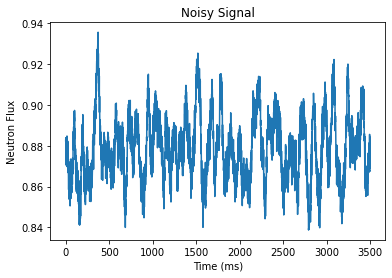

In [3]:
# Plot the noisy signal of scneario 6 detector 1
s = data_sc['6']['signal']

plt.plot(range(len(s[:,1])), s[:,1])
plt.title('Noisy Signal')
plt.ylabel('Neutron Flux')
plt.xlabel('Time (ms)')
plt.show()

Now for all the scenarios and for each of the 56 detectors, independently smooth the signal!

You can overwrite the signal in the dictionaries with the smoothed signal or save it as a new entry in the dictionary.

<br>

**Tip:**
refer back to the lecture for smoothing filters.

You can also use a built in function [scipy.signal.medfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html#scipy.signal.medfilt). *Hint: set k to change the width of the median window!*

If you do decide to implement yourself, try the median filter first and np.median() this is slightly simpler to implement!
```
for s in data_sc:
  signal = data_sc[s]['signal']
  for i in range(num_det):
    signal_d = signal[:,d]
    smoothed_signal = some_smoothing(signal_d)
    signal[:,d] = smoothed_signal
  data_sc[s]['dn_signal'] = signal
```

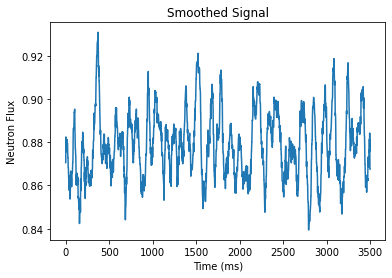

In [4]:
## TASK: YOUR CODE ##


k = 5
# Numpy Approach
for s in data_sc:
  signal = data_sc[s]['signal']
  for d in range(56):
    signal_d = signal[:,d]
    k2 = (k - 1) // 2
    y = np.zeros((len(signal_d), k))
    y[:,k2] = signal_d
    for i in range (k2):
        j = k2 - i
        y[j:,i] = signal_d[:-j]
        y[:j,i] = signal_d[0]
        y[:-j,-(i+1)] = signal_d[j:]
        y[-j:,-(i+1)] = signal_d[-1]
    dn_signal = np.mean(y, axis=1)
    signal[:,d] = dn_signal
  data_sc[s]['dn_signal'] = signal

# Scipy Approach
for s in data_sc:
  signal = data_sc[s]['signal']
  for d in range(56):
    signal_d = signal[:,d]
    dn_signal = sig.medfilt(signal_d, kernel_size=k)
    signal[:,d] = dn_signal
  data_sc[s]['dn_signal'] = signal
  
## END ##

# Plot the de-noised signal of scneario 6 detector 1
s = data_sc['6']['dn_signal']

plt.plot(range(len(s[:,1])), s[:,1])
plt.title('Smoothed Signal')
plt.ylabel('Neutron Flux')
plt.xlabel('Time (ms)')
plt.show()

## **Sliding Window**

Now we have clean sequences, we need to process the relatively long signal (T=3500 >> 35 seconds) into smaller sub-sequences for 3 reasons:


1.   We need more training samples.
2.   35 seconds is substantially long reading needed to detect an anomaly. In reality anomalies happen very very quickly (~1 second) so we will aim to detect anomalies given < 1 second of readings.
3.   Sequences of 3500 will be far to computationally expensive.


From our **'signal'** `(3501,56)` we want to end up with a new array of size: `(num_samples, window_size, 56)` per scenario.

Again you can overwrite your signal array in the dictionary or enter a new entry.



In [5]:
# These Params Control the Sliding Window
WIN_WIDTH = 100
OVERLAP = 5

## TASK: YOUR CODE ##
for s in data_sc:
  signal = data_sc[s]['dn_signal']

  #print(signal.shape[0])

  split_signal = []

  for window in range(0, signal.shape[0]-WIN_WIDTH, OVERLAP):
    signal_window = signal[window:window+WIN_WIDTH, :]

    split_signal.append(signal_window)

  split_signal = np.asarray(split_signal)

  data_sc[s]['split_signal'] = split_signal

## END ##

## **Train, Validation, and Test Set**
We now have a dictionary for each scenario containing the de-noised and windowed signal. But before we start building our classifier, we need to split our dataset into our Train and Evaluation sets.

We will undertake this in the most simple manner for this practical, 70% Train, 15% Validation, and 15% Test. This will be done along the time steps.

**Note:** The split must be done over time steps, we cannot have sequences of the same time window apprearing across sets, even if from different detectors.

To keep things simple, we'll take our processed signal once split and store them as numpy arrays 
```
Train_X = np.array() # (train_samples, window_size, 56)
Valid_X = np.array() # (test_samples, window_size, 56)
Test_X = np.array()  # (valid_samples, window_size, 56)

Train_Y = np.array() # (train_samples, 1)
Valid_Y = np.array() # (test_samples, 1)
Test_Y = np.array()  # (valid_samples, 1)
```

In [6]:
Train_X, Valid_X, Test_X = [], [] ,[]
Train_Y, Valid_Y, Test_Y = [], [] ,[]

# Params
train_fac = 0.7
val_fac = 0.15
test_fac = 0.15

## TASK: YOUR CODE ##

for s in data_sc:
  samples = data_sc[s]['split_signal']
  num_samples =  samples.shape[0]

  # Calculate the number of samples in each subset
  train_len = math.floor(num_samples * 0.7)
  val_len = math.floor(num_samples * 0.15)
  test_len = math.floor(num_samples * 0.15)

  # Add the appropriate number of samples to each subset.
  # Overlap is not carried between sets as the samples are ordered.
  Train_X += list(samples[:train_len,...])
  Valid_X += list(samples[train_len:(train_len+val_len),...])
  Test_X += list(samples[(train_len+val_len):(train_len+val_len+test_len),...])

  # Labels
  Train_Y += [data_sc[s]['one_hot']] * train_len
  Valid_Y += [data_sc[s]['one_hot']] * val_len
  Test_Y += [data_sc[s]['one_hot']] * test_len

# To numpy because numpy is nice :)
Train_X = np.asarray(Train_X)
Valid_X = np.asarray(Valid_X)
Test_X = np.asarray(Test_X)
Train_Y = np.asarray(Train_Y, dtype=np.int32)
Valid_Y = np.asarray(Valid_Y, dtype=np.int32)
Test_Y = np.asarray(Test_Y, dtype=np.int32)

## END ##

## **Data Normalisation**

Normalisation is a key step in data pre-processing for DNNs, ensuring all features have the same scale, and therefore ensuring all features are weighted equally in the learning procedure!

More info can be found here: https://developers.google.com/machine-learning/data-prep/transform/normalization 

So your task is to simply normalise each sample feature wise!

**Tip:**
Compute the mean and std for each set for each of the 56 detectors!

x = (x - x.mean()) / x.std()

In [7]:
## TASK: YOUR CODE ##
def norm(x):
  
  mean = x.mean(axis=(0,1))
  std = x.std(axis=(0,1))

  x = (x - mean) / (std + 1E-10)

  return x

Train_X = norm(Train_X)
Valid_X = norm(Valid_X)
Test_X = norm(Test_X)

## END ##

# **Build the Model**

Now it's time for the bit I find fun, building the classification networks!

I am asking you to build me both a CNN and RNN!

I have provided a rough layout via functions that define the models, but this is just my style. If you wish to code in a different style (i.e. using `Sequential()` [Doc](https://www.tensorflow.org/guide/keras/sequential_model)) then feel free to do so!

This is your work, make it your own!

## **RNN Classifier**
[RNN Keras Tutorial](https://www.tensorflow.org/guide/keras/rnn)\
[RNN Keras Documentation](https://keras.io/api/layers/#recurrent-layers)

In [8]:
def rnn_model(args, input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)

    ## TASK: YOUR CODE ##

    lstm1 = keras.layers.LSTM(2, return_sequences=True, kernel_regularizer=regularizers.l1_l2(l1=args['wd']*0.1, l2=args['wd']),
    bias_regularizer=regularizers.l2(args['wd']), recurrent_regularizer=regularizers.l2(args['wd']))(input_layer)

    lstm2 = keras.layers.LSTM(2, return_sequences=False, kernel_regularizer=regularizers.l1_l2(l1=args['wd']*0.1, l2=args['wd']),
    bias_regularizer=regularizers.l2(args['wd']), recurrent_regularizer=regularizers.l2(args['wd']))(lstm1)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(lstm2)

    ## END ##
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

## **CNN Classifier**
[CNN Keras Tutorial](https://www.tensorflow.org/tutorials/images/cnn)\
[CNN Keras Documentation](https://keras.io/api/layers/#convolution-layers)

In [9]:
def cnn_model(args, input_shape, num_classes):
    input_layer = keras.layers.Input(input_shape)

    ## TASK: YOUR CODE ##

    conv1 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same", kernel_regularizer=regularizers.l1_l2(l1=args['wd']*0.1, l2=args['wd']),
    bias_regularizer=regularizers.l2(args['wd']))(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.Dropout(args['drop'])(conv1)

    conv2 = keras.layers.Conv1D(filters=16, kernel_size=3, padding="same", kernel_regularizer=regularizers.l1_l2(l1=args['wd']*0.1, l2=args['wd']),
    bias_regularizer=regularizers.l2(args['wd']))(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(args['drop'])(conv2)

    conv3 = keras.layers.Conv1D(filters=32, kernel_size=3, padding="same", kernel_regularizer=regularizers.l1_l2(l1=args['wd']*0.1, l2=args['wd']),
    bias_regularizer=regularizers.l2(args['wd']))(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.Dropout(args['drop'])(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)
    ## END ##
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

# **Run the Model**

Now the bit where it all comes together!
I've provided alot of the code using my style, but as with the previous section feel free to adapt it to how you like to write!

## **Training Loop**

[Model Keras Documentation](https://keras.io/api/models/)

In [10]:
def train(args):

  # You can change these as you see fit!
  callbacks = [
    keras.callbacks.ModelCheckpoint("training/cp.ckpt", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=15, min_lr=0.0001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

  # Initialise your model
  model = cnn_model(args, input_shape=Train_X.shape[1:], num_classes=8)

  # Gradient Descent algorithm / Optimiser
  opt = keras.optimizers.Adam(learning_rate=0.01)

  # Compile the model
  model.compile(optimizer=opt,
      loss="categorical_crossentropy",
      metrics=["categorical_accuracy"],)
  
  # Train the model
  history = model.fit(
      Train_X,
      Train_Y,
      batch_size=args['batch_size'],
      epochs=args['epochs'],
      callbacks=callbacks,
      validation_data=(Valid_X,Valid_Y),
      verbose=1,
      shuffle=True
  )

  return history


## **Evaluation Loop**

In [11]:
def eval(args):
  # Load the Trained Model
  model = keras.models.load_model("training/cp.ckpt")

  # Test the model
  test_loss, test_acc = model.evaluate(Test_X, Test_Y)

  # Get the activations / Representations from the GAP layer
  # change '-1' to define which layer you want (-1 = last layer, -2 = second to last layer)
  get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[-1].output]) 
  output_rep = get_layer_output([Test_X])[0]

  print("Test accuracy", test_acc)
  print("Test loss", test_loss)

  return output_rep

## **Run**

To keep things clean and tidy to experiment, we define all the hyperparameters whilst launching the training. We parse the `args` dictionary to both the train and eval loop which contains all the user defined parameters!

**Tip:**
Be carful when training on this data that you don't *overfit* to the training set! You can implement the following to address this!\
[Weight Regularization](https://keras.io/api/layers/regularizers/)\
[Dropout](https://keras.io/api/layers/regularization_layers/dropout/)
\
\
If you have any errors just **Runtime -> Restart and run all**. This will end all currently operating cells, restart and run all cells sequentially

In [12]:
# HyperParams
args = {'epochs': 100, 'batch_size': 64, 'wd': 0.01, 'drop':0.25}

# Train the Network
history = train(args)

# Test the Network
output_rep = eval(args)

Epoch 1/100
60/60 [==============================] - 35s 18ms/step - loss: 1.8071 - categorical_accuracy: 0.6427 - val_loss: 1.8501 - val_categorical_accuracy: 0.2917
INFO:tensorflow:Assets written to: training/cp.ckpt/assets
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 0.3255 - categorical_accuracy: 0.9787 - val_loss: 1.5030 - val_categorical_accuracy: 0.6422
INFO:tensorflow:Assets written to: training/cp.ckpt/assets
Epoch 3/100
60/60 [==============================] - 1s 9ms/step - loss: 0.2683 - categorical_accuracy: 0.9897 - val_loss: 0.7738 - val_categorical_accuracy: 0.9338
INFO:tensorflow:Assets written to: training/cp.ckpt/assets
Epoch 4/100
60/60 [==============================] - 0s 7ms/step - loss: 0.2700 - categorical_accuracy: 0.9877 - val_loss: 0.9701 - val_categorical_accuracy: 0.7243
Epoch 5/100
60/60 [==============================] - 0s 8ms/step - loss: 0.3293 - categorical_accuracy: 0.9890 - val_loss: 2.0905 - val_categorical_accuracy: 0.6

## **Plot the Metrics**

Visualisation of the training metrics are one of the only ways we can as practitioners understand what is going on during training!

This in my opinion is the key tuning tool for improving our networks!

If you don't do this in your own work, I highly recommend you do :)

If you wish to encorporate tensorboard check out this [tutorial](https://keras.io/api/callbacks/tensorboard/)

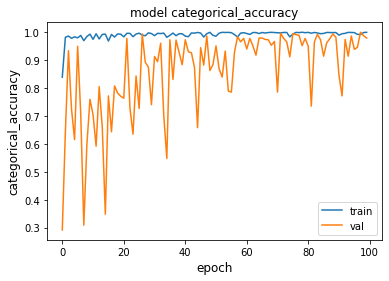

In [13]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

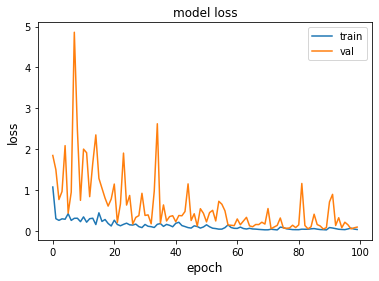

In [14]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

## **Visualise the Representations**

Now we have finished training our model, it is nice to see how our model represented the scenarios in representation space! We hope to see clusters of representations belonging to the same scenario.

So during testing (evaluation loop) we saved the output of our model that we feed to our classification layer.

To visualise this high-dimensional vector we employ [t-SNE](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) a unsupervised dimensionality reduction method!

Once in a more manageable dimension (2 dimensions (x,y)) we will plot the representations with their corresponding true label.

Your task is to simply perform the t-SNE visualisation, and you can use a pre-built package.

[t-SNE scikitlearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

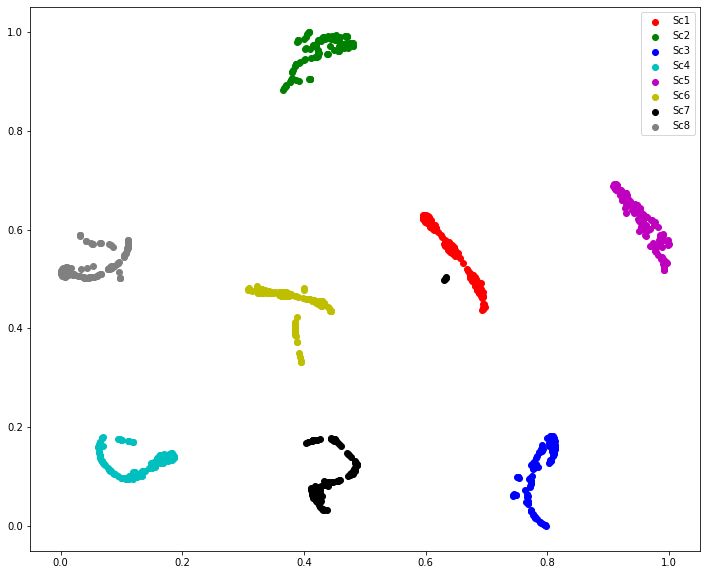

In [15]:
features = output_rep
targets = Test_Y

# One Hot encodings back to categorical labels.
targets = np.argmax(targets, axis=1)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2).fit_transform(features)

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

# scale and move the 'x' coordinates so they fit [0; 1] range
tx_range = (np.max(tx) - np.min(tx))
tx_from_zero = tx - np.min(tx)
tx = tx_from_zero / tx_range

# scale and move the 'y' coordinates so they fit [0; 1] range
ty_range = (np.max(ty) - np.min(ty))
ty_from_zero = ty - np.min(ty)
ty = ty_from_zero / ty_range

# Here is where we are going to plot our t-SNE visualisation
# we need to provide tx and ty above!

# Name the scenario numbers
label_names = ['Sc1','Sc2','Sc3','Sc4','Sc5','Sc6','Sc7','Sc8']
label_ids = range(len(label_names))

# Define the figure size
plt.figure(figsize=(12, 10))

# Define the colours of the classes/scenarios
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'grey'

# For each scenario plot the corresponding embeddings in their chosen colours
# tx and ty are output for t-SNE in 2-dimensions (x,y).
for i, c, label in zip(label_ids, colors, label_names):
  plt.scatter(tx[targets == i], ty[targets == i], c=c, label=label)

# Show the figure  
plt.legend()
plt.show()

## **That's all**

So today's practical session has asked you to process a real-world time series signal from a unique application domain. You have had to process with regard to domain expert knowledge, and also build a classifer to predict the anomaly type given neutron detector readings.

If you're interested in this application domain check out some other works:
- https://aura.abdn.ac.uk/bitstream/handle/2164/14170/Durrant_EPJN_3DConvolutional_VoR.pdf?sequence=1 
- https://www.epj-conferences.org/articles/epjconf/pdf/2021/01/epjconf_physor2020_21004.pdf 
- https://aidendurrant.github.io/Resources/MC2021_ADurrant_Preprint.pdf 

And if you still have time or want to work on this in your own time try out the bonus tasks listed at the top of this notebook :)

I hope you enjoyed this hands on practical!

\- Aiden

### **References:**
Today's practical was inspired by this [work](
https://aura.abdn.ac.uk/bitstream/handle/2164/14170/Durrant_EPJN_3DConvolutional_VoR.pdf?sequence=1)\
And the keras code was based on:
https://keras.io/examples/timeseries/timeseries_classification_from_scratch/  